## 🛣️ Clasificación de Criterios SMCA para Priorización de Mantenimiento Vial (PMV – Apartadó)

Este Análisis Espacial Multicriterio (SMCA) identifica y clasifica las zonas del municipio de Apartadó según su prioridad para el mantenimiento vial. El análisis integra tanto factores como restricciones, todos derivados de información geoespacial.
Se consideran las condiciones del terreno, la proximidad a infraestructura y la exposición a claseificación del suelo como insumos clave para orientar la toma de decisiones espaciales.

### ✅ Factores
| No. | Criterio                                   | Tipo SMCA     | Explicación                                                                                                                  |
| --- | ------------------------------------------ | ------------- | ---------------------------------------------------------------------------------------------------------------------------- |
| 1   | **Pendiente del terreno** | **Costo**     | Las pendientes pronunciadas aumentan el riesgo de erosión y dificultan el mantenimiento. Terrenos planos son más favorables. |
| 2   | **Vías existentes**           | **Beneficio** | La red vial actual de clasificación principal y complmentaria.                                          |
| 3   | **Proximidad a centros poblados**          | **Beneficio** | Se priorizan áreas cercanas a asentamientos, donde el impacto social del mantenimiento es mayor.                             |

### 🚫 Restricciones
| No. | Criterio                                   | Tipo SMCA       | Explicación                                                                             |
| --- | ------------------------------------------ | --------------- | --------------------------------------------------------------------------------------- |
| 4   | **Zonas con amenaza por remoción en masa** | **Restricción** | Áreas con alto riesgo de deslizamientos no son viables para intervenciones sostenibles. |
| 5   | **Zonas urbanas**     | **Restricción** | La clasificación del suelo urbano, tiene una mejor infrastructura, se debe priorizar la zona rural.                           |
| 6   | **Pendiente > 40 %**                       | **Restricción** | Terrenos con inclinación extrema son excluidos por limitaciones técnicas y ambientales. |


In [1]:
import rasterio
import numpy as np
from scipy.ndimage import distance_transform_edt
import matplotlib.pyplot as plt
from rasterio.features import rasterize
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.colors as mcolors


## Introducción al análisis
### Importar librerías

## Cargar capas ráster para el análisis de priorización de mantenimiento vial
En esta sección se cargan las capas ráster previamente procesadas, todas alineadas en cuanto a extensión espacial, resolución y sistema de referencia de coordenadas (CRS). Estas capas son la base para el análisis multicriterio de priorización de mantenimiento vial en el municipio de Apartadó.

Los insumos geoespaciales incluidos son:

- **Pendiente**: Derivada del Modelo de Elevación Digital (DEM), expresada en porcentaje (%). Representa la inclinación del terreno.
- **Buffer a centros poblados**: Ráster continuo generado a partir de la distancia a los núcleos urbanos y rurales. Áreas más cercanas se consideran de mayor prioridad.
- **Amenaza por remoción en masa**: Ráster binario donde el valor 1 indica zonas con alta susceptibilidad a deslizamientos, las cuales se excluirán del análisis.
- **Clasificación del suelo**: Ráster categórico simplificado en donde el valor 1 corresponde a suelo urbano (excluido) y 0 a suelo rural (prioritario).
- **Vías**: Ráster binario que representa la ubicación de la red vial actual (1 = vía, 0 = fondo). Se utilizará como referencia de conectividad e infraestructura existente.

Estas capas serán utilizadas para definir los factores (como pendiente o proximidad a centros poblados) y restricciones (como zonas de riesgo y áreas urbanas) en el proceso de evaluación espacial multicriterio.


In [2]:
# Define paths
m_root=r"/notebooks/Workshop_6/DATOS/capas_finales"

pendientes_path = m_root + "/pendiente.tif"
buffer_CP_path = m_root + "/buffer_centros_poblados_raster.tif"

Vias_raster_path = m_root + "/vias_raster.tif"
Suelo_raster_path = m_root + "/suelo_clase.tif"
Amenaza_RM_raster_path = m_root + "/remocion_masa.tif"

# Definir rutas de salida y cargar rásteres al análisis
pendientes_path        = m_root + "/pendiente.tif"
buffer_CP_path         = m_root + "/buffer_centros_poblados_raster.tif"
vias_raster_path       = m_root + "/vias_raster.tif"
suelo_raster_path      = m_root + "/suelo_clase.tif"
amenaza_rm_raster_path = m_root + "/remocion_masa.tif"

# Cargar todos los rásteres en memoria
with rasterio.open(pendientes_path) as src:
    pendiente = src.read(1)
    meta = src.meta
    transform = src.transform
    bounds = src.bounds
    print("✔ Pendiente cargada:", src.shape)

with rasterio.open(buffer_CP_path) as src:
    buffer_cp = src.read(1)
    print("✔ Buffer a centros poblados cargado:", src.shape)

with rasterio.open(vias_raster_path) as src:
    vias = src.read(1)
    print("✔ Vías rasterizadas cargadas:", src.shape)

with rasterio.open(suelo_raster_path) as src:
    suelo = src.read(1)
    print("✔ Clasificación del suelo cargada:", src.shape)

with rasterio.open(amenaza_rm_raster_path) as src:
    remocion = src.read(1)
    print("✔ Amenaza por remoción en masa cargada:", src.shape)


✔ Pendiente cargada: (1202, 1530)
✔ Buffer a centros poblados cargado: (1202, 1530)
✔ Vías rasterizadas cargadas: (1202, 1530)
✔ Clasificación del suelo cargada: (1202, 1530)
✔ Amenaza por remoción en masa cargada: (1202, 1530)


## Factores

## Capas base de factores continuos
En esta etapa se preparan las capas que representan factores de decisión dentro del modelo SMCA para priorización de mantenimiento vial. Estos factores incluyen variables continuas o transformadas espacialmente que permiten asignar niveles de prioridad relativos a cada celda del territorio.

Los factores considerados en este análisis son:

- **Pendiente del terreno**: derivada del Modelo de Elevación Digital (DEM), expresada en porcentaje. Zonas con menor pendiente son más favorables para intervenciones viales.
- **Buffer a centros poblados**: representa la distancia euclidiana en metros desde cada celda hasta el núcleo poblado más cercano. Zonas más cercanas son consideradas prioritarias.
- **Presencia de red vial**: capa binaria en la que los píxeles con valor 1 representan presencia de infraestructura vial. Esta capa podrá combinarse con otras para calcular zonas de influencia o accesibilidad.


In [4]:
# Invertir ráster binario: 1 = vía → 0 para aplicar la transformación
vias_inv = vias == 0

# Calcular distancia euclidiana en píxeles
dist_vias_px = distance_transform_edt(vias_inv)

# Convertir a unidades reales (metros) usando el tamaño del píxel
pixel_size = transform[0]  # ancho del píxel, extraído del transform del ráster
dist_vias_m = dist_vias_px * pixel_size

print("✔ Ráster de distancia a vías calculado en metros.")


✔ Ráster de distancia a vías calculado en metros.


In [7]:
print("Valores únicos en pendiente:", np.unique(pendiente))
print("Min:", np.nanmin(pendiente), "| Max:", np.nanmax(pendiente))


Valores únicos en pendiente: [-3.4028235e+38  0.0000000e+00  2.9557600e-04 ...  6.8696335e+01
  6.8948326e+01  6.9005867e+01]
Min: -3.4028235e+38 | Max: 69.00587


In [8]:
# Reemplazar solo el valor nodata, sin afectar los valores reales
nodata_val = -3.4028235e+38
pendiente_clean = np.where(pendiente == nodata_val, np.nan, pendiente)


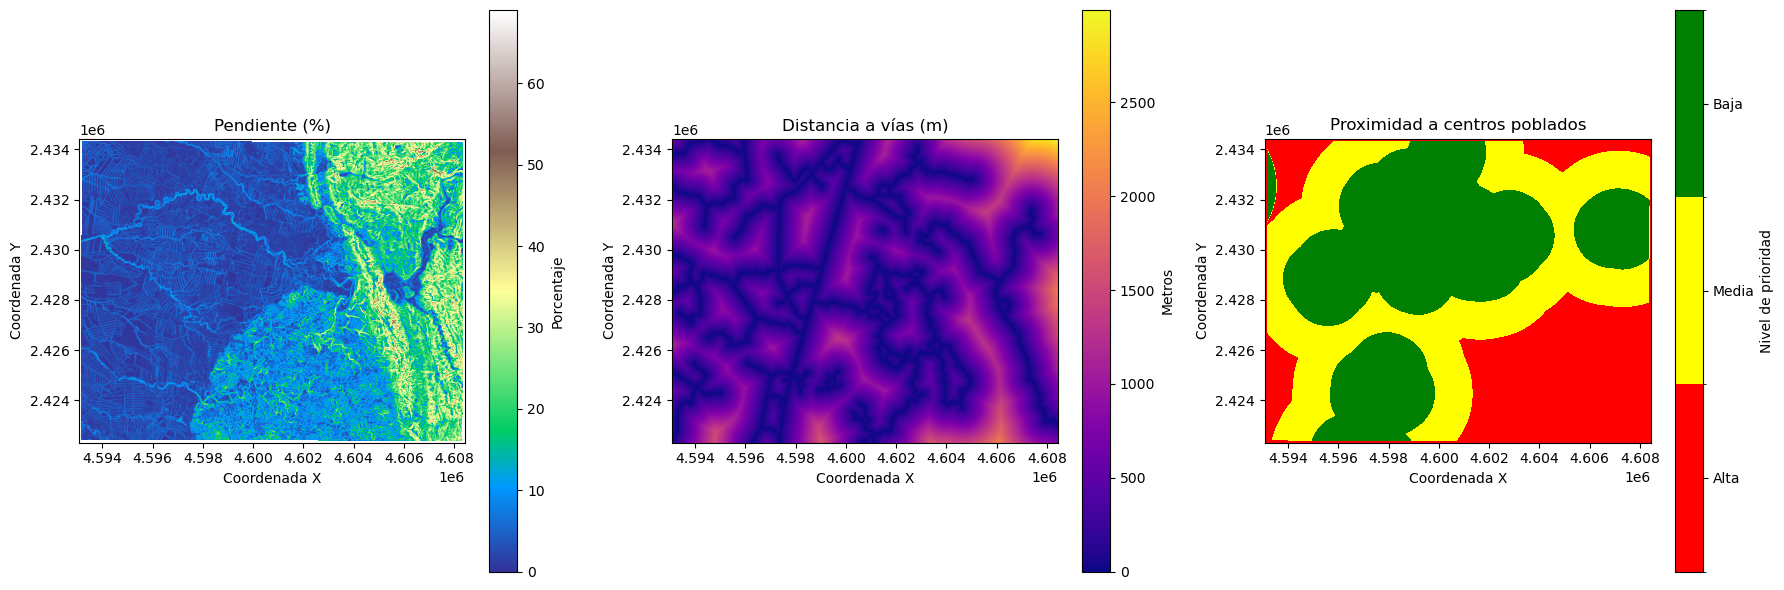

In [10]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Definir colormap discreto para categorías 1 (alta), 2 (media), 3 (baja)
cmap_cp = ListedColormap(['red', 'yellow', 'green'])
bounds_cp_cat = [0.5, 1.5, 2.5, 3.5]
norm_cp = BoundaryNorm(bounds_cp_cat, cmap_cp.N)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Pendiente
img1 = axs[0].imshow(pendiente_clean, cmap='terrain',
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[0].set_title("Pendiente (%)", fontsize=12)
plt.colorbar(img1, ax=axs[0], label="Porcentaje")

# 2. Distancia a vías
img2 = axs[1].imshow(dist_vias_m, cmap='plasma',
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[1].set_title("Distancia a vías (m)", fontsize=12)
plt.colorbar(img2, ax=axs[1], label="Metros")

# 3. Categoría de proximidad a centros poblados
img3 = axs[2].imshow(buffer_cp, cmap=cmap_cp, norm=norm_cp,
                     extent=[bounds.left, bounds.right, bounds.bottom, bounds.top])
axs[2].set_title("Proximidad a centros poblados", fontsize=12)
cbar = plt.colorbar(img3, ax=axs[2], ticks=[1, 2, 3])
cbar.ax.set_yticklabels(["Alta", "Media", "Baja"])
cbar.set_label("Nivel de prioridad")

# Ajustes generales
for ax in axs:
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")
    ax.grid(False)

plt.tight_layout()
plt.show()


### Normalización de Factores para el Análisis Multicriterio Espacial (SMCA)
Para combinar múltiples capas espaciales con diferentes unidades y escalas, todos los factores deben ser transformados a una escala común de adecuación de 0 a 100, donde:

- **100**= condición más prioritaria (máxima necesidad de mantenimiento)
- **0**= condición menos prioritaria (mínima o nula prioridad)

A continuación se describe la lógica de normalización aplicada a cada uno de los factores considerados:

---

1. Pendiente del terreno
- **Tipo**: Costo → pendientes más bajas implican mayor prioridad
- **Justificación**: Las pendientes elevadas dificultan las obras de mantenimiento vial por riesgos de erosión, costos técnicos y accesibilidad limitada.
- **Método de normalización**: Transformación lineal de tipo costo
- **Umbrales**:
    - `0% de pendiente` → prioridad = 100
    - `≥ 40% de pendiente` → prioridad = 0
    - Disminución lineal entre 0% y 40%

---

2. Distancia a vías existentes
- **Tipo**: Costo → menor distancia implica mayor prioridad
- **Justificación**: Las zonas más cercanas a la red vial existente tienen mayor accesibilidad y permiten una intervención más eficiente.
- **Método de normalización**: Transformación lineal de tipo costo
- **Umbrales**:
    - `0 m de distancia a vía` → prioridad = 100
    - `≥ 2000 m → prioridad` = 0
    - Disminución lineal entre 0 y 2000 m

---

3. Proximidad a centros poblados
- **Tipo**: Beneficio categórico → mayor prioridad en zonas cercanas a población
- **Justificación**: Las áreas con mayor cercanía a centros poblados benefician directamente a más personas y tienen mayor impacto social.
- **Método de normalización**: Asignación discreta por categoría
- **Escala**:
    - `Categoría 1 (Alta proximidad)` → prioridad = 100
    - `Categoría 2 (Media proximidad)` → prioridad = 50
    - `Categoría 3 (Baja proximidad)` → prioridad = 0
---

Al final del proceso, todas las capas (`pendiente_norm`, `dist_vias_norm`, `cp_norm`) estarán en la misma escala de prioridad (0–100), listas para ser ponderadas y combinadas en el modelo SMCA.


In [11]:
import numpy as np

# --- 1. Normalizar la pendiente (factor de costo) ---

def normalise_slope_cost(slope_array, threshold=40.0):
    """
    Normaliza pendiente como un factor de costo.
    0% de pendiente = prioridad 10; ≥ threshold% = prioridad 0.
    Decrecimiento lineal.
    """
    slope_clipped = np.clip(slope_array, 0, threshold)
    norm = 10 * (threshold - slope_clipped) / threshold
    return np.clip(norm, 0, 10)

# Aplicar normalización
pendiente_norm = normalise_slope_cost(pendiente_clean, threshold=40.0)
print("✅ Pendiente normalizada (0–10): >40% = no prioritario (0)")


# --- 2. Normalizar distancia a vías (factor de costo) ---

def normalise_proximity_cost(dist_array, threshold=2000.0):
    """
    Normaliza distancia como factor de costo.
    0 m = prioridad 10; ≥ threshold = prioridad 0.
    Decrecimiento lineal.
    """
    clipped = np.clip(dist_array, 0, threshold)
    norm = 10 * (1 - clipped / threshold)
    return np.clip(norm, 0, 10)

dist_vias_norm = normalise_proximity_cost(dist_vias_m, threshold=2000)
print("✅ Distancia a vías normalizada (0–10): más cerca = más prioritario")


# --- 3. Normalizar proximidad a centros poblados (factor categórico) ---

def normalise_categoric_cp(cp_array):
    """
    Asigna prioridad según categoría de proximidad:
    1 = alta → 10; 2 = media → 5; 3 = baja → 0
    """
    norm = np.zeros_like(cp_array, dtype=float)
    norm[cp_array == 1] = 10
    norm[cp_array == 2] = 5
    norm[cp_array == 3] = 0
    return norm

cp_norm = normalise_categoric_cp(buffer_cp)
print("✅ Proximidad a centros poblados normalizada (0–10): categoría discreta")


✅ Pendiente normalizada (0–10): >40% = no prioritario (0)
✅ Distancia a vías normalizada (0–10): más cerca = más prioritario
✅ Proximidad a centros poblados normalizada (0–10): categoría discreta


### Comparación visual de factores originales vs. normalizados
Visualización lado a lado de las capas originales y sus versiones normalizadas en una escala de 0 a 10.

Este ejemplo muestra:
- **Pendiente** (pendiente_clean vs pendiente_norm)
- **Distancia a vías** (dist_vias_m vs dist_vias_norm)
- **Proximidad a centros poblados** (buffer_cp vs cp_norm)


Visualización de pendiente entre 0.29 y 36.87


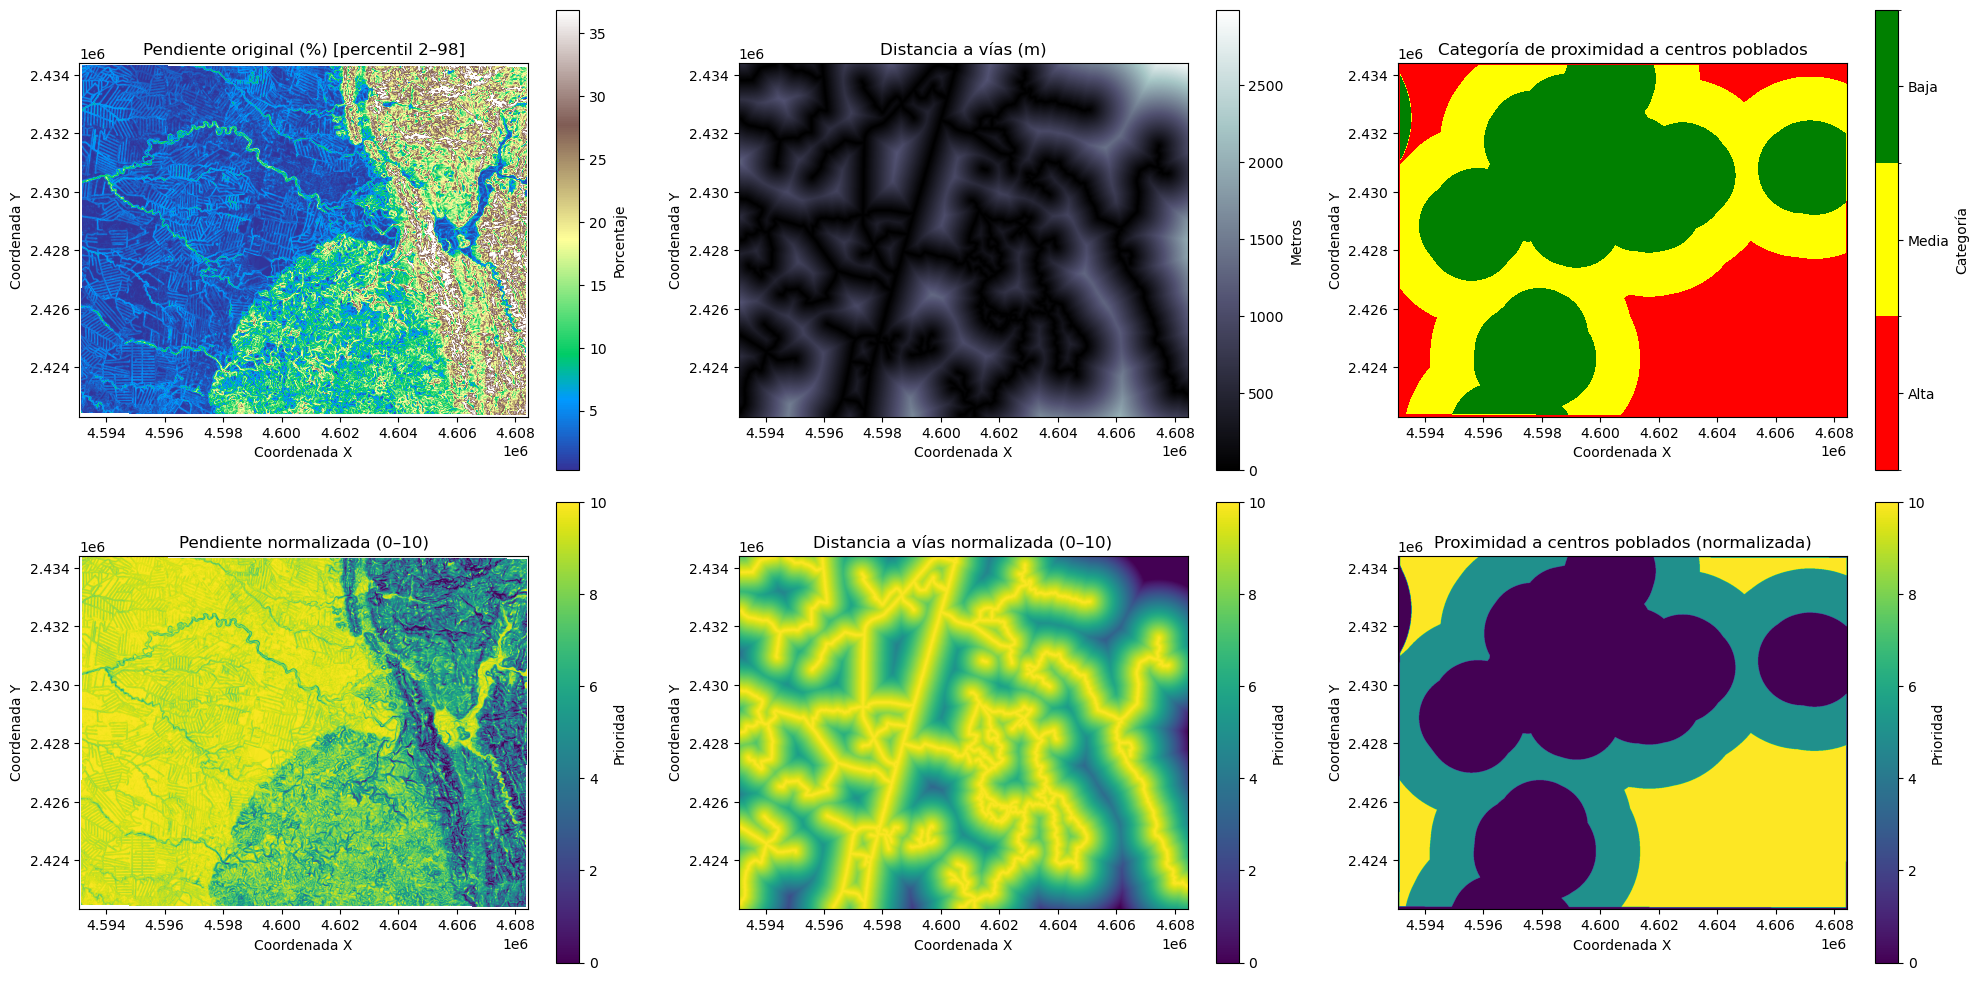

In [12]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Calcular rango de visualización para pendiente (evita valores extremos)
pendiente_min = np.percentile(pendiente_clean[pendiente_clean > 0], 2)
pendiente_max = np.percentile(pendiente_clean[pendiente_clean > 0], 98)
print(f"Visualización de pendiente entre {pendiente_min:.2f} y {pendiente_max:.2f}")

# Crear extensión del ráster desde bounds
extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

# Crear figura 2x3
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

# Fila 1: Factores originales
im1 = axs[0, 0].imshow(pendiente_clean, cmap="terrain", extent=extent, origin="upper", 
                       vmin=pendiente_min, vmax=pendiente_max)
axs[0, 0].set_title("Pendiente original (%) [percentil 2–98]")
plt.colorbar(im1, ax=axs[0, 0], label="Porcentaje")

im2 = axs[0, 1].imshow(dist_vias_m, cmap="bone", extent=extent, origin="upper")
axs[0, 1].set_title("Distancia a vías (m)")
plt.colorbar(im2, ax=axs[0, 1], label="Metros")

# Capa categórica de centros poblados (1,2,3)
cmap_cp = ListedColormap(['red', 'yellow', 'green'])
bounds_cp_cat = [0.5, 1.5, 2.5, 3.5]
norm_cp = BoundaryNorm(bounds_cp_cat, cmap_cp.N)
im3 = axs[0, 2].imshow(buffer_cp, cmap=cmap_cp, norm=norm_cp, extent=extent, origin="upper")
axs[0, 2].set_title("Categoría de proximidad a centros poblados")
cbar3 = plt.colorbar(im3, ax=axs[0, 2], ticks=[1, 2, 3])
cbar3.ax.set_yticklabels(["Alta", "Media", "Baja"])
cbar3.set_label("Categoría")

# Fila 2: Factores normalizados (escala 0–10)
im4 = axs[1, 0].imshow(pendiente_norm, cmap="viridis", extent=extent, origin="upper", vmin=0, vmax=10)
axs[1, 0].set_title("Pendiente normalizada (0–10)")
plt.colorbar(im4, ax=axs[1, 0], label="Prioridad")

im5 = axs[1, 1].imshow(dist_vias_norm, cmap="viridis", extent=extent, origin="upper", vmin=0, vmax=10)
axs[1, 1].set_title("Distancia a vías normalizada (0–10)")
plt.colorbar(im5, ax=axs[1, 1], label="Prioridad")

im6 = axs[1, 2].imshow(cp_norm, cmap="viridis", extent=extent, origin="upper", vmin=0, vmax=10)
axs[1, 2].set_title("Proximidad a centros poblados (normalizada)")
plt.colorbar(im6, ax=axs[1, 2], label="Prioridad")

# Etiquetas comunes
for ax in axs.flat:
    ax.set_xlabel("Coordenada X")
    ax.set_ylabel("Coordenada Y")
    ax.grid(False)

plt.tight_layout()
plt.show()


In [13]:
print("✅ Formas de los rásteres (filas, columnas):\n")

print(f"Pendiente normalizada:                {pendiente_norm.shape}")
print(f"Distancia normalizada a vías:         {dist_vias_norm.shape}")
print(f"Proximidad normalizada a poblados:    {cp_norm.shape}")


✅ Formas de los rásteres (filas, columnas):

Pendiente normalizada:                (1202, 1530)
Distancia normalizada a vías:         (1202, 1530)
Proximidad normalizada a poblados:    (1202, 1530)


## Restricciones

### Crear la máscara combinada de restricciones
En esta sección se genera una máscara binaria de restricción que integra todos los criterios espaciales de exclusión definidos para el análisis de priorización de mantenimiento vial.

Cada restricción se transforma previamente en un ráster binario, donde:

- `1` representa una celda restringida (no priorizable)
- `0` representa una celda válida (apta para evaluación)

Las máscaras individuales se combinan mediante la función np.maximum.reduce, lo que garantiza que cualquier celda marcada como restringida por al menos uno de los criterios sea excluida en el resultado final.

El resultado es una capa binaria donde:

- `1` indica una zona excluida del análisis por condiciones no aptas o inviables
- `0` indica una zona permitida para continuar con la evaluación de prioridad




In [24]:
# === 1. Remoción en masa (binaria: 1 = excluido)
remocion_mask = (remocion == 3).astype("uint8")

# === 2. Suelo urbano (1 = urbano = excluido)
suelo_mask = (suelo == 1).astype("uint8")

# === 3. Pendiente mayor a 40 % (1 = excluido)
pendiente_restriccion_mask = (pendiente_clean > 40).astype("uint8")

# === 4. Combinar las tres restricciones
restriction_mask = np.maximum.reduce([
    remocion_mask,
    suelo_mask,
    pendiente_restriccion_mask
])

print("✅ Máscara combinada de restricciones generada.")
print("Valores únicos:", np.unique(restriction_mask))  # Debe devolver [0 1]


✅ Máscara combinada de restricciones generada.
Valores únicos: [0 1]


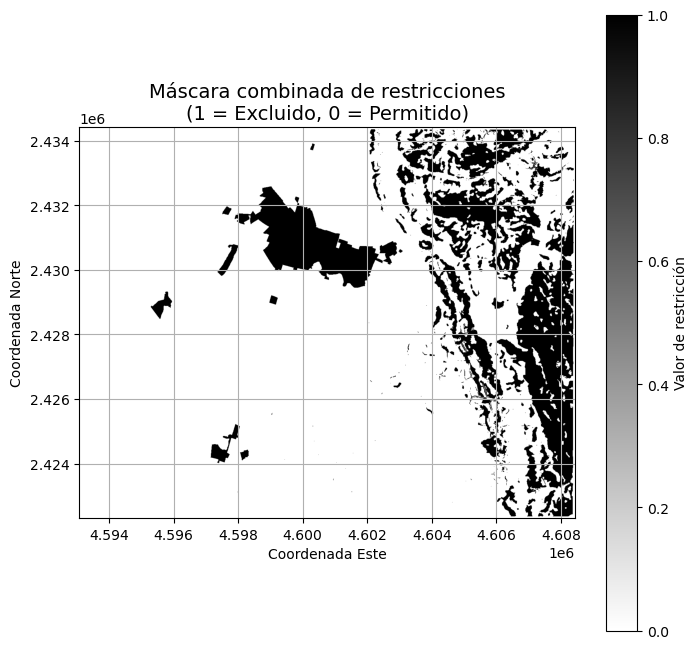

In [25]:
# Extensión espacial desde transform
xmin, ymax = transform * (0, 0)
xmax, ymin = transform * (restriction_mask.shape[1], restriction_mask.shape[0])
extent = [xmin, xmax, ymin, ymax]

plt.figure(figsize=(8, 8))
plt.imshow(restriction_mask, cmap="gray_r", extent=extent, origin="upper")
plt.title("Máscara combinada de restricciones\n(1 = Excluido, 0 = Permitido)", fontsize=14)
plt.xlabel("Coordenada Este")
plt.ylabel("Coordenada Norte")
plt.grid(True)
plt.colorbar(label="Valor de restricción")
plt.show()


## Suma ponderada

### Matrices de comparación pareada para ponderación de criterios

Para integrar múltiples factores en el análisis multicriterio espacial (SMCA), se aplica el Proceso Analítico Jerárquico (AHP) de Saaty. Esta metodología permite asignar pesos relativos a cada criterio mediante comparaciones pareadas, basadas en su importancia para la toma de decisiones.

A continuación, se presentan tres matrices de ejemplo con distintos enfoques de priorización:

---

#### Importancia igualitaria

Todos los criterios se consideran igualmente importantes para la priorización del mantenimiento vial.

|                       | Pendiente | Proximidad a vías | Proximidad a centros poblados |
| --------------------- | :-------: | :---------------: | :---------------------------: |
| **Pendiente**         |     1     |         1         |               1               |
| **Proximidad a vías** |     1     |         1         |               1               |
| **Proximidad a CP**   |     1     |         1         |               1               |

**Pesos resultantes**:
- Pendiente: 0.333
- Vías: 0.333
- Centros poblados: 0.333

---

#### Prioridad a la proximidad vial

Se da mayor peso a la cercanía a la red vial, por su papel en la logística y conexión territorial.

|                       | Pendiente | Proximidad a vías | Proximidad a centros poblados |
| --------------------- | :-------: | :---------------: | :---------------------------: |
| **Pendiente**         |     1     |        1/3        |               1               |
| **Proximidad a vías** |     3     |         1         |               3               |
| **Proximidad a CP**   |     1     |        1/3        |               1               |

**Pesos resultantes**:
- Pendiente: 0.211
- Vías: 0.578
- Centros poblados: 0.211

---

#### Prioridad a la pendiente
Se asume que las condiciones topográficas son el principal factor limitante para la intervención vial.

|                       | Pendiente | Proximidad a vías | Proximidad a centros poblados |
| --------------------- | :-------: | :---------------: | :---------------------------: |
| **Pendiente**         |     1     |         5         |               5               |
| **Proximidad a vías** |    1/5    |         1         |               1               |
| **Proximidad a CP**   |    1/5    |         1         |               1               |

**Pesos resultantes**:
- Pendiente: 0.625
- Vías: 0.188
- Centros poblados: 0.188


In [26]:
# === Paso 1: Definir matrices de pesos normalizados (comparaciones por pares) ===

# 1. Igual importancia — todos los factores contribuyen por igual
pesos_igual = {
    "pendiente": 1/3,
    "vias": 1/3,
    "centros_poblados": 1/3
}

# 2. Prioridad en vías — la proximidad vial es el factor más importante
pesos_vias = {
    "pendiente": 0.25,
    "vias": 0.5,
    "centros_poblados": 0.25
}

# 3. Prioridad en pendiente — la pendiente es el factor más crítico
pesos_pendiente = {
    "pendiente": 0.5,
    "vias": 0.25,
    "centros_poblados": 0.25
}


# === Paso 2: Calcular aptitud ponderada (escala 0–10) para cada escenario ===

def calcular_aptitud(pesos, pendiente_n, vias_n, cp_n):
    """
    Calcula el puntaje de aptitud total usando combinación lineal ponderada.
    Los pesos se pasan como diccionario.
    """
    return (pesos["pendiente"] * pendiente_n +
            pesos["vias"] * vias_n +
            pesos["centros_poblados"] * cp_n)

# Calcular mapas de aptitud para cada escenario
aptitud_igual = calcular_aptitud(pesos_igual, pendiente_norm, dist_vias_norm, cp_norm)
aptitud_vias = calcular_aptitud(pesos_vias, pendiente_norm, dist_vias_norm, cp_norm)
aptitud_pendiente = calcular_aptitud(pesos_pendiente, pendiente_norm, dist_vias_norm, cp_norm)


# === Paso 3: Aplicar máscara de restricciones ===
# Zonas restringidas (valor 1 en la máscara) se asignan como -1 para excluirlas del análisis

aptitud_igual_masked = np.where(restriction_mask == 1, -1, aptitud_igual)
aptitud_vias_masked = np.where(restriction_mask == 1, -1, aptitud_vias)
aptitud_pendiente_masked = np.where(restriction_mask == 1, -1, aptitud_pendiente)

print("✅ Mapas de aptitud ponderada calculados y con máscara aplicada (zonas restringidas = -1).")


✅ Mapas de aptitud ponderada calculados y con máscara aplicada (zonas restringidas = -1).


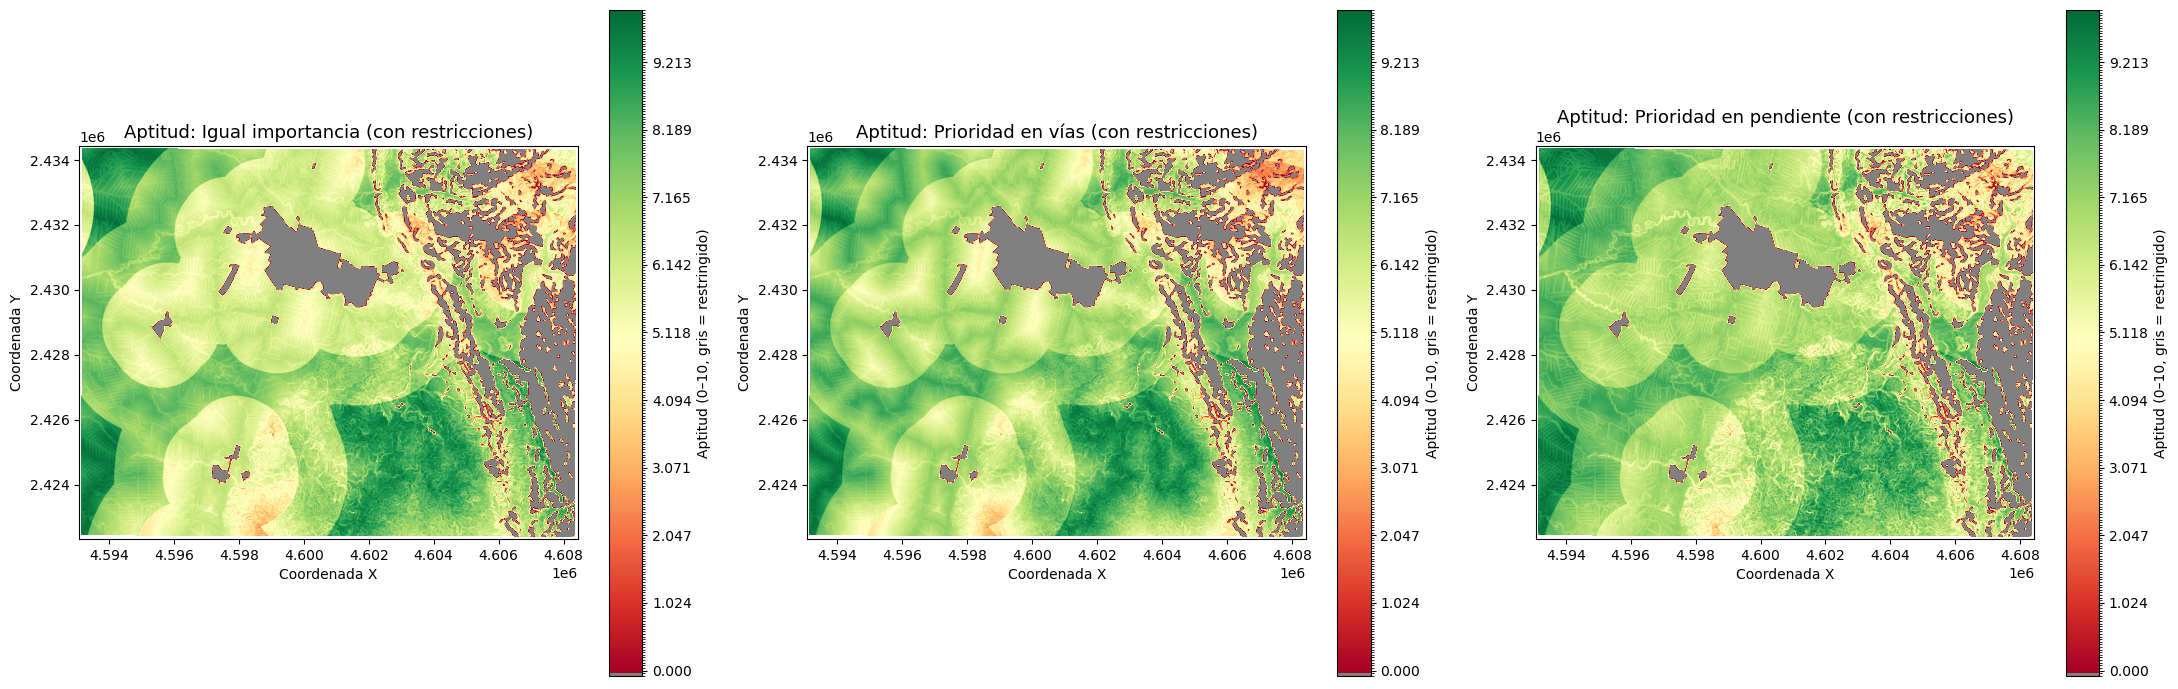

In [27]:
# Crear un mapa de colores personalizado: rojo (0) a verde (10), gris para zonas restringidas (-1)

# Colormap base de rojo a verde
cmap_base = plt.cm.RdYlGn

# Agregar color gris para representar zonas restringidas (-1)
cmap_con_restriccion = mcolors.ListedColormap(['grey'] + [cmap_base(i) for i in range(cmap_base.N)])

# Normalizador que asigna -1 a gris y el resto en escala continua 0–10
limites = [-1.5, -0.5] + list(np.linspace(0, 10, cmap_base.N - 1))
norma = mcolors.BoundaryNorm(limites, cmap_con_restriccion.N)

# === Visualización de mapas de aptitud con restricciones ===
fig, axs = plt.subplots(1, 3, figsize=(22, 7))

# Escenario 1: Igual importancia
im1 = axs[0].imshow(aptitud_igual_masked, cmap=cmap_con_restriccion, norm=norma, extent=extent, origin="upper")
axs[0].set_title("Aptitud: Igual importancia (con restricciones)", fontsize=13)
axs[0].set_xlabel("Coordenada X")
axs[0].set_ylabel("Coordenada Y")
plt.colorbar(im1, ax=axs[0], label="Aptitud (0–10, gris = restringido)")

# Escenario 2: Prioridad en vías
im2 = axs[1].imshow(aptitud_vias_masked, cmap=cmap_con_restriccion, norm=norma, extent=extent, origin="upper")
axs[1].set_title("Aptitud: Prioridad en vías (con restricciones)", fontsize=13)
axs[1].set_xlabel("Coordenada X")
axs[1].set_ylabel("Coordenada Y")
plt.colorbar(im2, ax=axs[1], label="Aptitud (0–10, gris = restringido)")

# Escenario 3: Prioridad en pendiente
im3 = axs[2].imshow(aptitud_pendiente_masked, cmap=cmap_con_restriccion, norm=norma, extent=extent, origin="upper")
axs[2].set_title("Aptitud: Prioridad en pendiente (con restricciones)", fontsize=13)
axs[2].set_xlabel("Coordenada X")
axs[2].set_ylabel("Coordenada Y")
plt.colorbar(im3, ax=axs[2], label="Aptitud (0–10, gris = restringido)")

plt.tight_layout()
plt.show()


## Clasificación y visualización de la aptitud territorial

Una vez calculados los puntajes de aptitud ponderada y aplicada la máscara de restricciones, el paso final del análisis consiste en clasificar los valores continuos de aptitud (rango 0–10) en categorías discretas. Esta clasificación facilita la interpretación y la toma de decisiones al agrupar el territorio en niveles de prioridad claramente diferenciados.

El esquema de clasificación empleado es el siguiente:

- **Áreas restringidas** (`-1`) se mantienen y se etiquetan como **0** (color **gris**),
- **Baja aptitud**: valores entre `0.1` y `3.3` → **1** (color **rojo**),
- **Media aptitud**: valores entre `3.3` y `6.6` → **2** (color **amarillo**),
- **Alta aptitud**: valores mayores a `6.6` → **3** (color **verde**).

Esta clasificación se aplica a cada uno de los tres escenarios considerados:

1. Importancia igual entre todos los factores,
2. Priorización de la proximidad a vías,
3. Priorización de la aptitud según la pendiente.

Los mapas resultantes utilizan una paleta de colores consistente para facilitar la comparación entre escenarios. Se incluye una leyenda compartida que indica el significado de cada clase de aptitud.


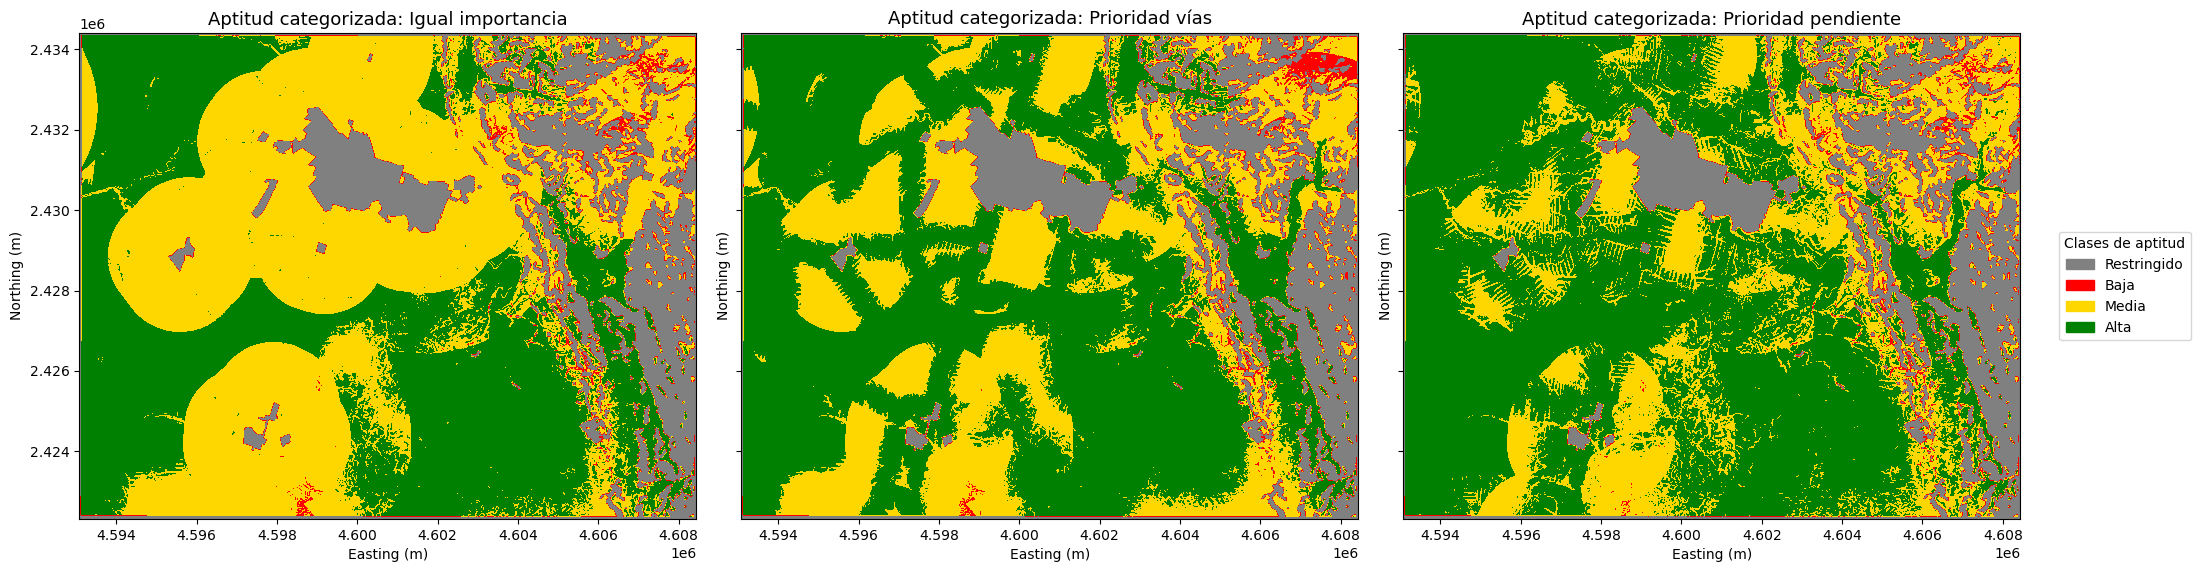

In [28]:
# === Clasificación de aptitud en 4 clases: 0 = restringido, 1–3 = niveles de aptitud ===

def clasificar_aptitud(array_masked):
    """
    Clasifica los valores normalizados de aptitud (0–10) en 3 niveles:
    1 = baja, 2 = media, 3 = alta. Las zonas restringidas (-1) se codifican como 0.
    """
    clasificado = np.full_like(array_masked, 0)  # Todo inicia como zona restringida (0)
    clasificado[(array_masked > 0) & (array_masked <= 3.3)] = 1  # Baja aptitud
    clasificado[(array_masked > 3.3) & (array_masked <= 6.6)] = 2  # Media aptitud
    clasificado[array_masked > 6.6] = 3  # Alta aptitud
    return clasificado

# Aplicar la clasificación a los tres escenarios
aptitud_igual_clas = clasificar_aptitud(aptitud_igual_masked)
aptitud_vias_clas = clasificar_aptitud(aptitud_vias_masked)
aptitud_pendiente_clas = clasificar_aptitud(aptitud_pendiente_masked)

# === Visualización de la clasificación categórica ===

# Definir colores: 0 = gris (restringido), 1 = rojo (baja), 2 = amarillo (media), 3 = verde (alta)
colores_clases = ListedColormap(["grey", "red", "gold", "green"])
etiquetas_clases = ["Restringido", "Baja", "Media", "Alta"]
limites = [-0.5, 0.5, 1.5, 2.5, 3.5]
norma = BoundaryNorm(limites, colores_clases.N)

# Crear figura de 3 paneles
fig, axs = plt.subplots(1, 3, figsize=(22, 7), sharex=True, sharey=True)

# Escenario 1: Igual importancia
im1 = axs[0].imshow(aptitud_igual_clas, cmap=colores_clases, norm=norma, extent=extent, origin="upper")
axs[0].set_title("Aptitud categorizada: Igual importancia", fontsize=13)
axs[0].set_xlabel("Easting (m)")
axs[0].set_ylabel("Northing (m)")

# Escenario 2: Prioridad vías
im2 = axs[1].imshow(aptitud_vias_clas, cmap=colores_clases, norm=norma, extent=extent, origin="upper")
axs[1].set_title("Aptitud categorizada: Prioridad vías", fontsize=13)
axs[1].set_xlabel("Easting (m)")
axs[1].set_ylabel("Northing (m)")

# Escenario 3: Prioridad pendiente
im3 = axs[2].imshow(aptitud_pendiente_clas, cmap=colores_clases, norm=norma, extent=extent, origin="upper")
axs[2].set_title("Aptitud categorizada: Prioridad pendiente", fontsize=13)
axs[2].set_xlabel("Easting (m)")
axs[2].set_ylabel("Northing (m)")

# Leyenda compartida
from matplotlib.patches import Patch
parches_leyenda = [Patch(color=colores_clases(i), label=etiqueta) for i, etiqueta in enumerate(etiquetas_clases)]
fig.legend(handles=parches_leyenda, loc='center right', title="Clases de aptitud")

# Ajuste de diseño
plt.tight_layout(rect=[0, 0, 0.93, 1])  # deja espacio a la derecha para la leyenda
plt.show()
